In [36]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [37]:
df = pd.read_csv("data.csv")

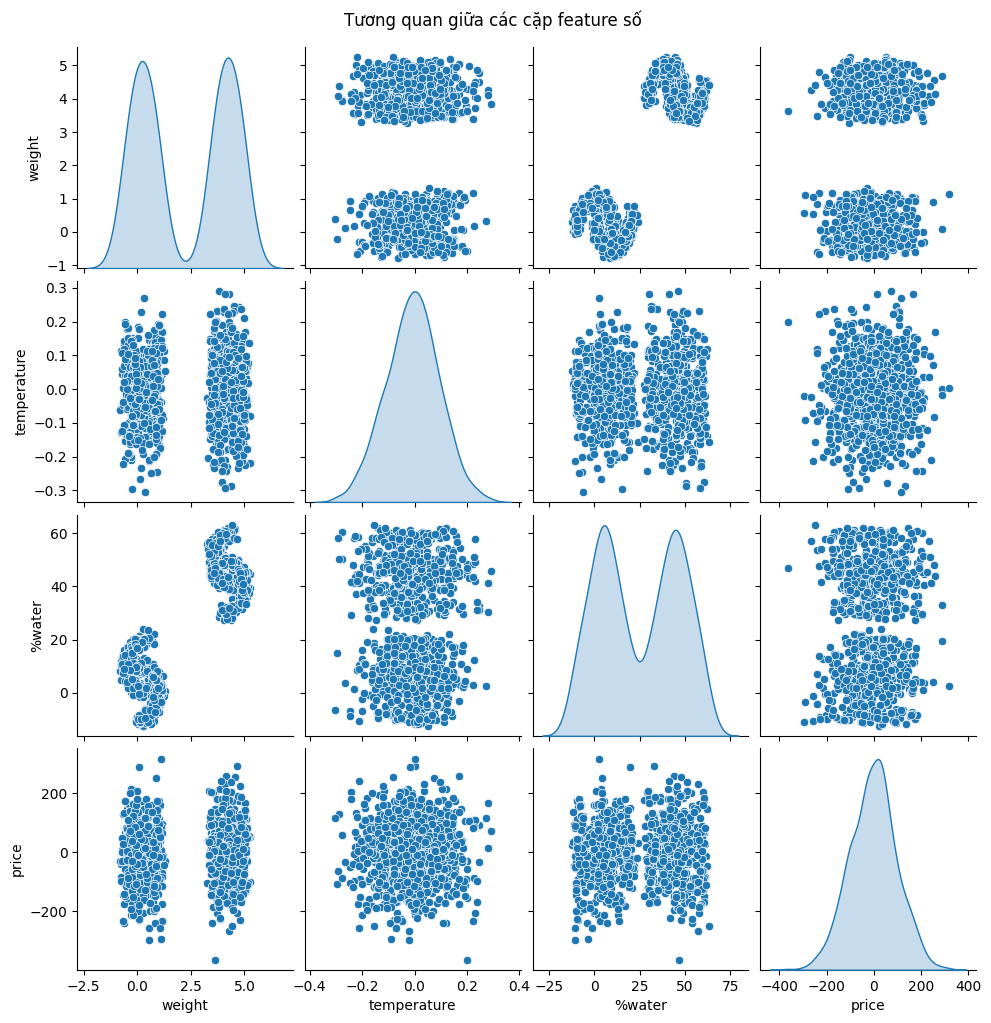

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lấy các cột số
num_features = ["weight", "temperature", "%water", "price"]

# 1. Vẽ ma trận scatterplot để xem tương quan giữa các cặp feature số
sns.pairplot(df[num_features], diag_kind="kde")
plt.suptitle("Tương quan giữa các cặp feature số", y=1.02)
plt.show()

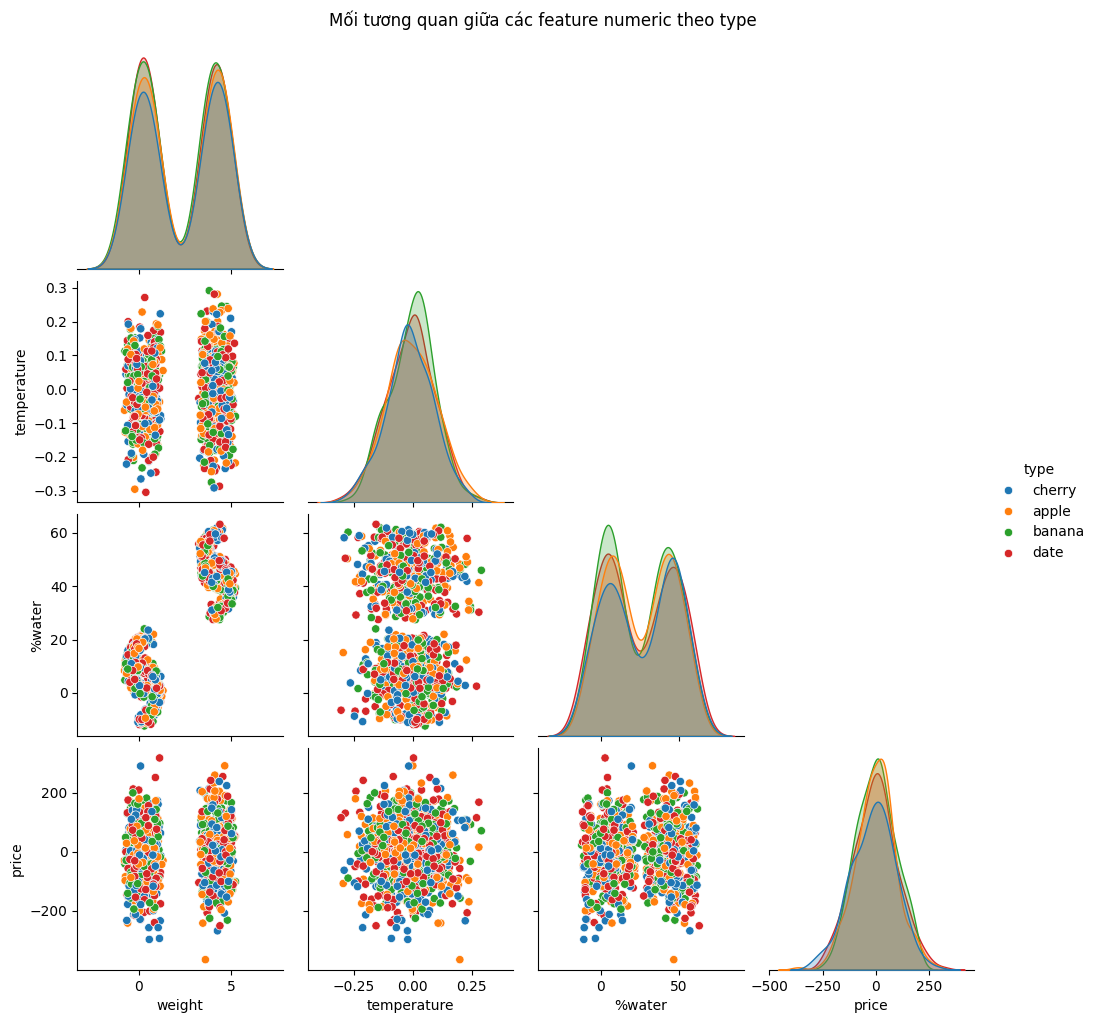

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Chỉ lấy các feature numeric (trừ type)
features = ["weight", "temperature", "%water", "price"]

# Vẽ pairplot, hue = type
sns.pairplot(df[features + ["type"]], hue="type", diag_kind="kde", corner=True)

plt.suptitle("Mối tương quan giữa các feature numeric theo type", y=1.02)
plt.show()

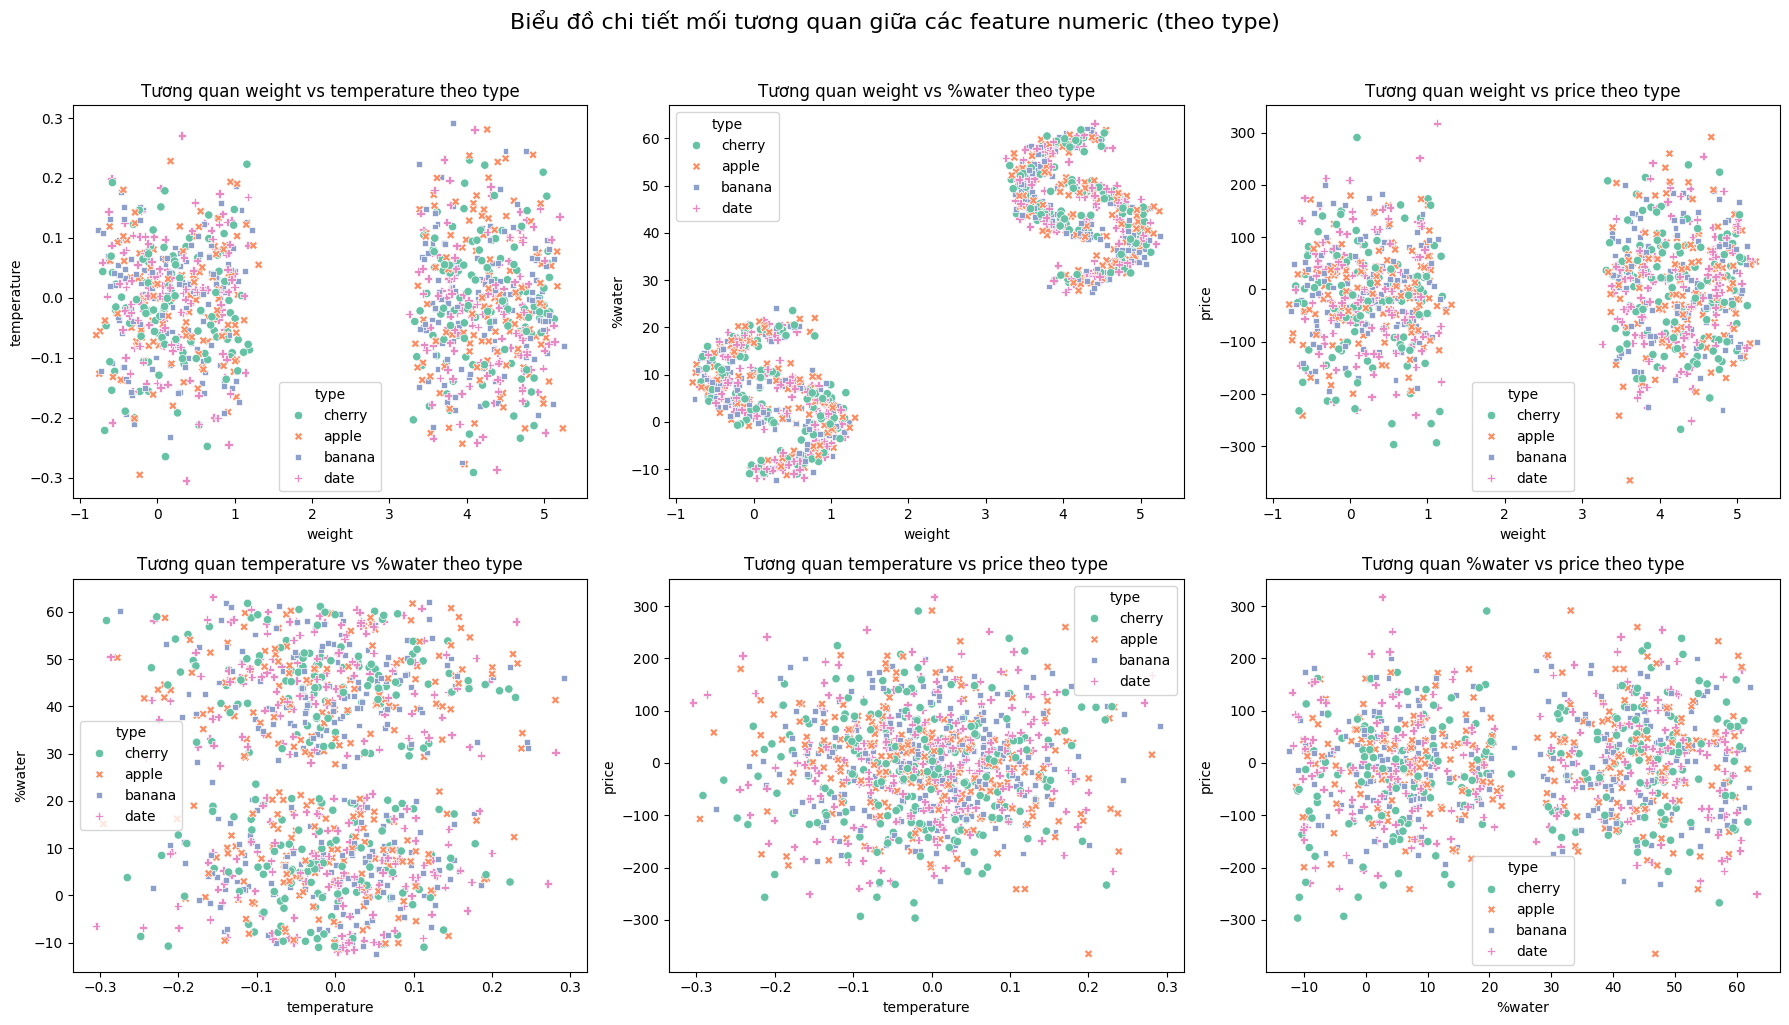

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Các feature numeric
features = ["weight", "temperature", "%water", "price"]

# Lấy tất cả các cặp (combinations) 2 feature
pairs = list(itertools.combinations(features, 2))

# Tạo figure với subplots
n_pairs = len(pairs)
n_cols = 3
n_rows = (n_pairs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, (x, y) in enumerate(pairs):
    sns.scatterplot(
        data=df,
        x=x, y=y,
        hue="type",
        palette="Set2",
        style="type",
        ax=axes[i]
    )
    axes[i].set_title(f"Tương quan {x} vs {y} theo type")

# Xóa subplot thừa (nếu có)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Biểu đồ chi tiết mối tương quan giữa các feature numeric (theo type)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Nhận thấy rằng sự phân biệt giữa các label thể hiện khá rõ ràng trong mối tương quan giữa weight và %water, vậy nên ta DBSCAN trên 2 features này.

In [41]:
# Chọn 2 feature
X = df[["weight", "%water"]].values

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Vẽ biểu đồ Elbow để xác định eps cho DBSCAN.

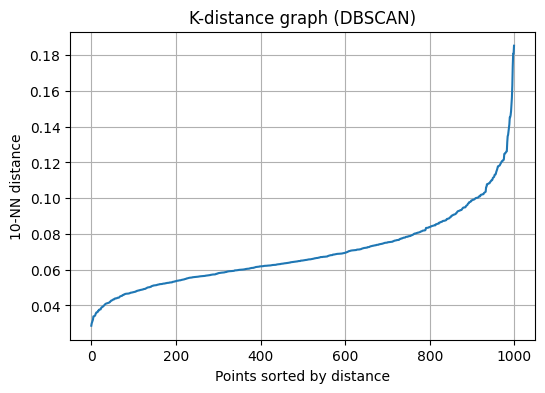

In [42]:
# 4. Tính k-distance (k = min_samples)
min_samples = 10
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# khoảng cách tới k-th nearest neighbor (cột cuối cùng)
k_distances = np.sort(distances[:, -1])

# 5. Vẽ biểu đồ
plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-NN distance")
plt.title("K-distance graph (DBSCAN)")
plt.grid(True)
plt.show()

In [43]:
# Huấn luyện DBSCAN / Phân loại các nhãn và phân loại noise
dbscan = DBSCAN(eps=0.08485, min_samples=10)  # eps có thể điều chỉnh
labels = dbscan.fit_predict(X_scaled)

# Tìm điểm có nhãn gần noise nhất để gán nhãn
# Copy nhãn ban đầu
final_labels = labels.copy()

# Xác định noise
mask_noise = labels == -1
mask_cluster = labels != -1

# Nếu có noise thì xử lý
if np.any(mask_noise):
    # Dùng NearestNeighbors trên các điểm thuộc cluster
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(X_scaled[mask_cluster])
    
    # Tìm hàng xóm gần nhất cho noise
    distances, indices = neigh.kneighbors(X_scaled[mask_noise])
    
    # Gán nhãn của hàng xóm đó cho noise
    for i, noise_idx in enumerate(np.where(mask_noise)[0]):
        nearest_idx = indices[i][0]
        nearest_label = labels[mask_cluster][nearest_idx]
        final_labels[noise_idx] = nearest_label


# Ánh xạ cluster về 4 nhãn (0,1,2,3) / Tips and Tricks
mapping = {
    0: 2, 1: 0, 2: 3, 3: 1, -1: -1
}

# Mapping nhãn
df["label"] = [mapping[l] for l in final_labels]

# Xuất file submission.csv
submission = pd.DataFrame({
    "id": df["id"],
    "label": df['label']
})
submission.to_csv("submission.csv", index=False)
print("✅ File submission.csv đã được tạo!")

# 0.99

✅ File submission.csv đã được tạo!


Vẽ biểu đồ thể hiện label của các điểm dữ liệu.

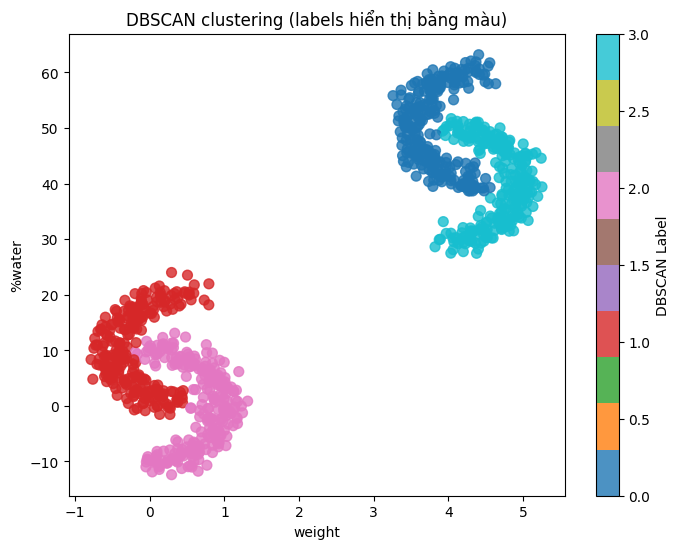

In [44]:
# Vẽ scatter plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    df["weight"], df["%water"],
    c=df["label"], cmap="tab10", s=50, alpha=0.8
)

plt.xlabel("weight")
plt.ylabel("%water")
plt.title("DBSCAN clustering (labels hiển thị bằng màu)")
plt.colorbar(scatter, label="DBSCAN Label")
plt.show()